# Loss functions

The choice of the loss function is vital for deep learning models, we have shown in our case studies that the default cosine similarity loss function is effective to predict the RNA velocity. Alternatively, a couple of additional loss functions are available, including the `mix` loss function which is a linear combination of the cosine similarity loss function and a harmonic function to constrain the magnitude of the predicted RNA velocity, and a root mean square error (`RMSE`) loss function which minimizes the deviation of the predicted from the observed RNA velocity vector,

$$L_{j}^{RMSE} = \max_{\{j'\}}(\vec{v}_j-\vec{v}_{j'})^2$$


In [1]:
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt

## Load gastrulation erythroid maturation data 

The input data for cellDancer contains the abundances of unspliced RNA and spliced RNA. For the detail of obtaining the dataset and pre-processing steps, [Data Preparation](data_preprocessing.html) could be referred to. We follow the standard Data Preparation procedures in [scVelo](https://scvelo.readthedocs.io/) with default parameters except that we use 100 nearest neighbors for first-moment calculation.

The data of gastrulation erythroid maturation could be downloaded and unzipped from [GastrulationErythroid_cell_type_u_s.csv.zip](https://drive.google.com/file/d/1DSbxJr5dh-NJp4Bx20tNlZHSjGjyigw-/view?usp=sharing). It could be loaded by ```pd.read_csv('your_path/GastrulationErythroid_cell_type_u_s.csv')```. To load your own data, the dataframe should contain columns 'gene_name', 'unsplice', 'splice' ,'cellID' ,'clusters' ,'embedding1' , and 'embedding2.' For a detailed description of the data structure, [Preprocessing](data_preprocessing.html) could be referred to.

In [2]:
cell_type_u_s_path='~/pseudotime/data/Gastrulation/raw_data/mouse_endo_blood20to25_2000_genes_moment100.csv'
cell_type_u_s=pd.read_csv(cell_type_u_s_path)
cell_type_u_s

,gene_list,u0,s0,cellID,clusters,embedding1,embedding2
0,Sox17,0.000000,0.043971,cell_363,Blood progenitors 2,3.460521,15.574629
1,Sox17,0.000000,0.000000,cell_382,Blood progenitors 2,2.490433,14.971734
2,Sox17,0.000000,0.018161,cell_385,Blood progenitors 2,2.351203,15.267069
3,Sox17,0.000000,0.000000,cell_393,Blood progenitors 2,5.899098,14.388825
4,Sox17,0.000000,0.000000,cell_398,Blood progenitors 2,4.823139,15.374831
...,...,...,...,...,...,...,...
24657995,Gm47283,0.214961,1.145533,cell_139318,Erythroid3,8.032358,7.603037
24657996,Gm47283,0.300111,1.072944,cell_139321,Erythroid3,10.352904,6.446736
24657997,Gm47283,0.292607,1.199875,cell_139326,Erythroid3,9.464873,7.261099
24657998,Gm47283,0.266031,1.114659,cell_139327,Erythroid3,9.990495,7.243880


In [4]:
cell_type_u_s.rename(columns={'gene_list':'gene_name', 'u0':'unsplice', 's0':'splice'}, inplace=True)

In [5]:
cell_type_u_s

,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,Sox17,0.000000,0.043971,cell_363,Blood progenitors 2,3.460521,15.574629
1,Sox17,0.000000,0.000000,cell_382,Blood progenitors 2,2.490433,14.971734
2,Sox17,0.000000,0.018161,cell_385,Blood progenitors 2,2.351203,15.267069
3,Sox17,0.000000,0.000000,cell_393,Blood progenitors 2,5.899098,14.388825
4,Sox17,0.000000,0.000000,cell_398,Blood progenitors 2,4.823139,15.374831
...,...,...,...,...,...,...,...
24657995,Gm47283,0.214961,1.145533,cell_139318,Erythroid3,8.032358,7.603037
24657996,Gm47283,0.300111,1.072944,cell_139321,Erythroid3,10.352904,6.446736
24657997,Gm47283,0.292607,1.199875,cell_139326,Erythroid3,9.464873,7.261099
24657998,Gm47283,0.266031,1.114659,cell_139327,Erythroid3,9.990495,7.243880


## Estimate RNA velocity for sample genes

```cd.velocity()``` could be used to estimate the velocity. 

Here, 15 genes in ```gene_list``` are estimated as an example. By default, the Deep Neural Network (DNN) will be trained at most 200 epochs. It checks the loss every 10 epochs. If the loss has no improvement in 3 checked epochs, the epoch will be ended. The network at that time will be used for the estimation. If supported by equipment, parallel computing could be used to improve the speed, ```n_jobs``` could be adjusted according to demand.

Finally, the predicted unspliced and spliced reads, alpha, beta, and gamma are added to the original dataframe and returned.

In [24]:
sys.path.append('~/cellDancer/src')
import celldancer as cd
from celldancer.velocity_estimation import velocity
gene_list=['Smarca2', 'Rbms2']

dancers = []
dt = 0.5
for loss in ('cosine', ('mix', 0.5), 'rmse'):
    loss_df, cellDancer_df=velocity(cell_type_u_s,\
                                gene_list=gene_list,\
                                permutation_ratio=0.125,\
                                n_jobs=1,
                                dt=dt,
                                loss_func=loss
                                )
    dancers.append(cellDancer_df)

Using /Users/pengzhizhang/cellDancer/analysis/cellDancer_velocity_2022-10-07 17-11-52 as the output path.
Arranging genes for parallel job.
2  genes were arranged to  2  portions.


Using /Users/pengzhizhang/cellDancer/analysis/cellDancer_velocity_2022-10-07 17-12-02 as the output path.
Arranging genes for parallel job.
2  genes were arranged to  2  portions.


Using /Users/pengzhizhang/cellDancer/analysis/cellDancer_velocity_2022-10-07 17-12-12 as the output path.
Arranging genes for parallel job.
2  genes were arranged to  2  portions.


Using /Users/pengzhizhang/cellDancer/analysis/cellDancer_velocity_2022-10-07 17-12-22 as the output path.
Arranging genes for parallel job.
2  genes were arranged to  2  portions.


Using /Users/pengzhizhang/cellDancer/analysis/cellDancer_velocity_2022-10-07 17-12-33 as the output path.
Arranging genes for parallel job.
2  genes were arranged to  2  portions.


Using /Users/pengzhizhang/cellDancer/analysis/cellDancer_velocity_2022-10-07 17-12-44 as the output path.
Arranging genes for parallel job.
2  genes were arranged to  2  portions.


## Visualize the phase portraits of sample genes

Let’s visualize the phase portrait of each gene with ```cdplt.scatter_gene()```.

From the figures below, the prediction of those genes that have transcriptional boost (Hba-x, Smim1, and Hbb-y) are consistent with the real-time progression of gastrulation erythroid maturation of (1) haemato-endothelial progenitors, (2) blood progenitors 1/2, and (3) erythroid. This reflects the ability of cellDancer to resolve the RNA velocity for the genes in the transcriptional boost scenario.

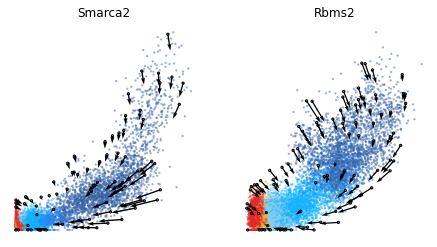

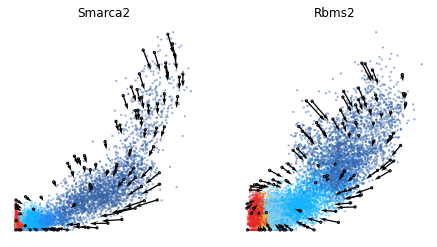

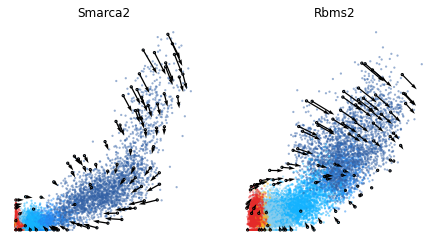

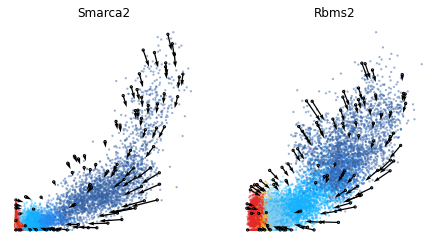

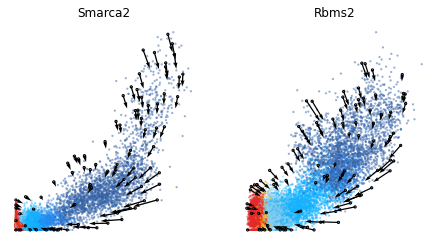

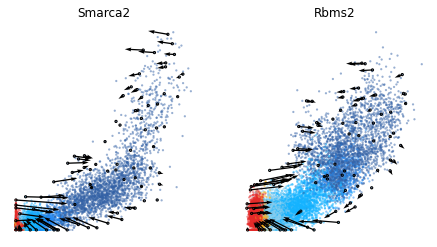

In [25]:
from celldancer.cdplt import scatter_gene
from celldancer.cdplt import colormap
for dancer in dancers:
    ncols=5
    height=math.ceil(len(gene_list)/5)*4
    fig = plt.figure(figsize=(20,height))

    for i in range(len(gene_list)):
        ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
        scatter_gene(
            ax=ax,
            x='splice',
            y='unsplice',
            cellDancer_df=dancer,
            custom_xlim=None,
            custom_ylim=None,
            colors=colormap.colormap_erythroid,
            alpha=0.5, 
            s = 5,
            velocity=True,
            gene=gene_list[i])
        
        ax.set_title(gene_list[i])
        ax.axis('off')

    plt.show()

## Load velocity estimation result of 2,000 genes

To project the prediction of RNA velocity to vector fields in embedding space and to estimate pseudotime by using all genes, all the 2,000 genes have already been predicted and could be downloaded and unzipped from [GastrulationErythroid_cellDancer_estimation.csv.zip](https://drive.google.com/file/d/1J4GB-Bn2SdmK56wXka5TdvkImspPwIjH/view?usp=sharing). The .csv file could be loaded by ```pd.read_csv()```.

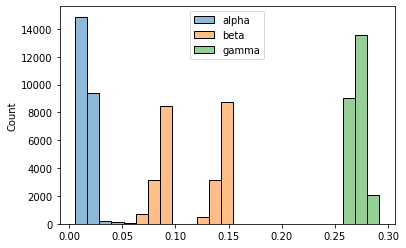

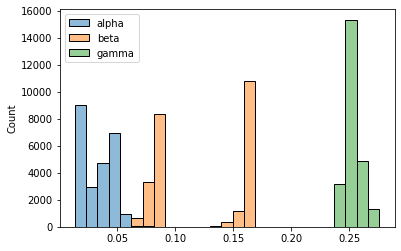

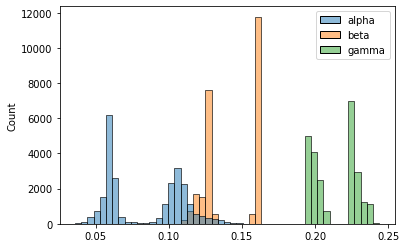

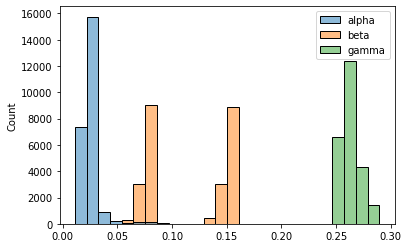

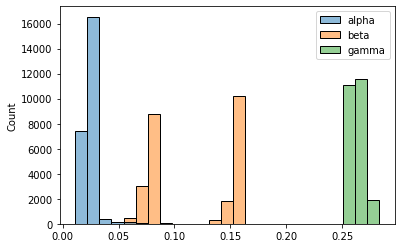

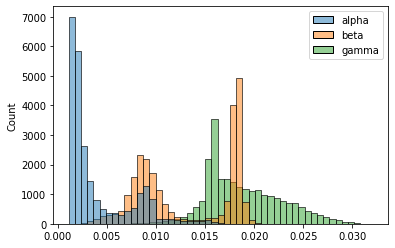

In [26]:
import seaborn as sns
for dancer in dancers:
    sns.histplot(dancer[['alpha', 'beta', 'gamma']])
    plt.show()

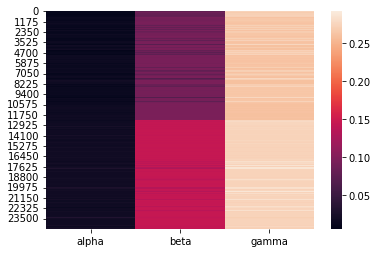

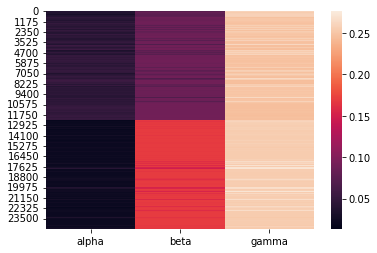

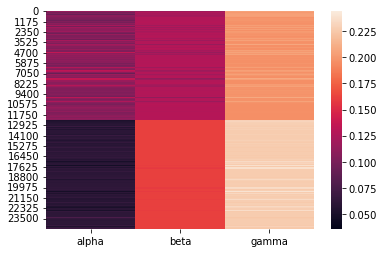

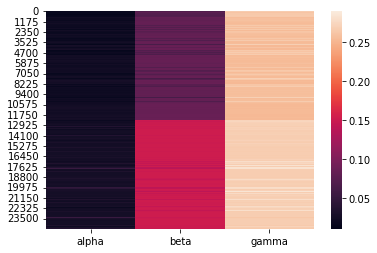

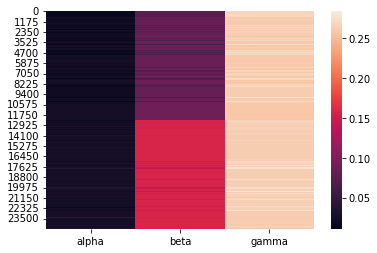

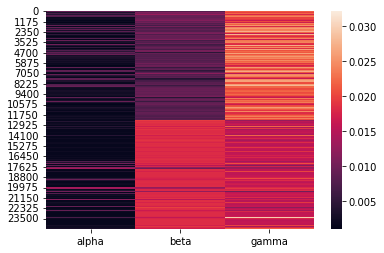

In [27]:
import seaborn as sns
for dancer in dancers:
    sns.heatmap(dancer[['alpha', 'beta', 'gamma']])
    plt.show()

## Project the RNA velocity to vector fields in the embedding space

The projection of RNA velocity in the embedding space could be calculated with ```cd.compute_cell_velocity()```. If not specified, all genes in cellDancer_df will be used to calculate the projection of RNA velocity in the embedding space. We project the velocity vectors of the cells into the low-dimensional embedding space following the method of [velocyto](https://velocyto.org/velocyto.py/index.html#) and [scVelo](https://scvelo.readthedocs.io/).

After the calculation, the projected direction in the embedding space, i.e. columns 'velocity1' and 'velocity2' will be added to the original dataframe. ```cdplt.scatter_cell()``` could be used to display the predicted direction in embedding space.

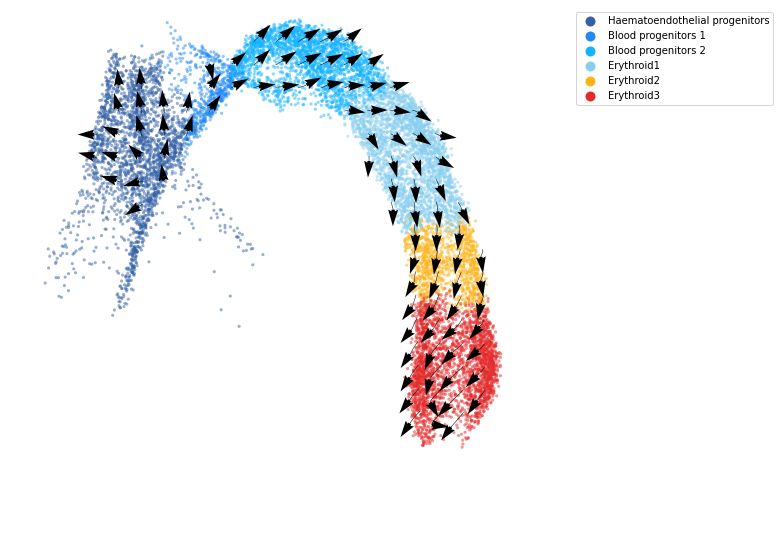

In [6]:
# compute cell velocity
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df, projection_neighbor_choice='gene', expression_scale='power10', projection_neighbor_size=10, speed_up=(100,100))

# plot cell velocity
fig, ax = plt.subplots(figsize=(10,10))
cdplt.scatter_cell(ax,
                   cellDancer_df,
                   colors=colormap.colormap_erythroid, 
                   alpha=0.5, 
                   s=10,
                   velocity=True,
                   legend='on',
                   min_mass=15,
                   arrow_grid=(20,20),
                   custom_xlim=[-6,13], 
                   custom_ylim=[2,16], )
ax.axis('off')
plt.show()

In [7]:
cellDancer_df

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2,index,velocity1,velocity2
0,0,Ift81,0.010658,0.026321,0.009261,0.029549,0.023595,0.042598,0.073999,0.039626,cell_363,Blood progenitors 2,3.460521,15.574629,0,NaN,NaN
1,1,Ift81,0.000000,0.044266,0.000946,0.037888,0.020649,0.042942,0.074502,0.039626,cell_382,Blood progenitors 2,2.490433,14.971734,1,NaN,NaN
2,2,Ift81,0.000000,0.064559,0.000885,0.055191,0.019326,0.042876,0.075031,0.039626,cell_385,Blood progenitors 2,2.351203,15.267069,2,NaN,NaN
3,3,Ift81,0.000000,0.020756,0.001014,0.017791,0.022149,0.043030,0.073879,0.039626,cell_393,Blood progenitors 2,5.899098,14.388825,3,NaN,NaN
4,4,Ift81,0.000000,0.013184,0.001037,0.011305,0.022633,0.043055,0.073676,0.039626,cell_398,Blood progenitors 2,4.823139,15.374831,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24657995,12324,Mcrip1,0.000000,1.128435,0.000157,1.125867,0.005920,0.038023,0.013131,0.051755,cell_139318,Erythroid3,8.032358,7.603037,12324,NaN,NaN
24657996,12325,Mcrip1,0.024356,0.970672,0.016090,1.428982,0.008338,0.037053,0.013950,0.051755,cell_139321,Erythroid3,10.352904,6.446736,12325,NaN,NaN
24657997,12326,Mcrip1,0.000000,0.899107,0.000175,0.897000,0.006575,0.037644,0.013522,0.051755,cell_139326,Erythroid3,9.464873,7.261099,12326,NaN,NaN
24657998,12327,Mcrip1,0.017375,1.398107,0.011387,1.729827,0.006885,0.037765,0.013271,0.051755,cell_139327,Erythroid3,9.990495,7.243880,12327,NaN,NaN


## Estimate pseudotime

Based on the projection of RNA velocity in embedding space, the pseudotime could be estimated with ```cd.pseudo_time()```.

In [8]:
%%capture
import random
# set parameters
dt = 0.05
t_total = {dt:int(10/dt)} 
n_repeats = 10

# estimate pseudotime
cellDancer_df = cd.pseudo_time(cellDancer_df=cellDancer_df, 
                               grid=(30,30), 
                               dt=dt, 
                               t_total=t_total[dt], 
                               n_repeats=n_repeats, 
                               speed_up=(100,100),
                               n_paths = 3,
                               psrng_seeds_diffusion=[i for i in range(n_repeats)],
                               activate_umap_paths_divider=False,
                               n_jobs=8)

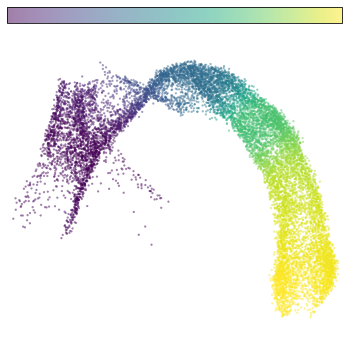

In [9]:
# plot pseudotime
fig, ax = plt.subplots(figsize=(6,6))
im=cdplt.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=0.5, velocity=False, custom_xlim=(-5,11), custom_ylim=(4,18))
ax.axis('off')
plt.show()

The connection network below is another method to display pseudotime (```cdplt.PTO_Graph```). The edge lengths indicate the time difference between nodes (the closer in pseudotime, the shorter the edge length). The sizes of the nodes are proportional to the 
pseudotime.

<AxesSubplot:>

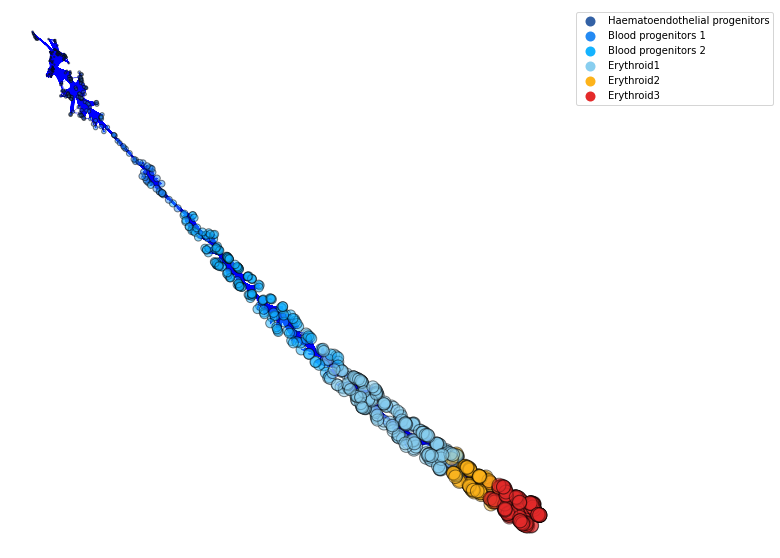

In [10]:
fig, ax= plt.subplots(figsize=(10,10))

cdplt.PTO_Graph(ax,
                cellDancer_df,
                node_layout='forcedirected',
                PRNG_SEED=10,
                use_edge_bundling=True,
                node_colors=colormap.colormap_erythroid,
                edge_length=3,
                node_sizes='pseudotime',
                colorbar='on',
                legend='on')

## Display the abundance of spliced RNA along pseudotime

Let’s visualize the spliced RNA abundance of some sample genes along pseudotime with ```cdplt.scatter_gene()```.

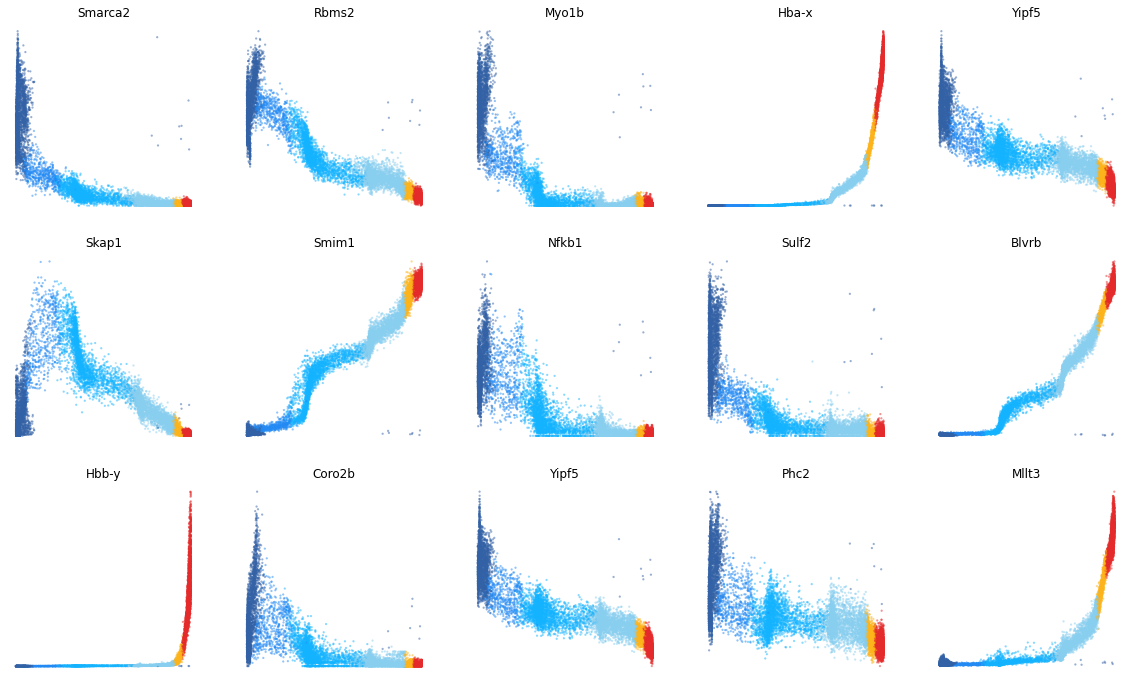

In [11]:
ncols=5
height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.scatter_gene(
        ax=ax,
        x='pseudotime',
        y='splice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_erythroid,
        alpha=0.5, 
        s = 5,
        velocity=False,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

## Project the RNA velocity to vector fields in the embedding space for transcriptional boost genes

In the study of [Barile et al.](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02414-y), they deprecate Multiple Rate Kinetics (MURK) genes when projecting the RNA velocity to vector fields in the embedding space. At first, the prediction of cell velocity in embedding space is not consistent with the real-time progression of gastrulation erythroid maturation. They identify MURK genes where the unspliced versus spliced slope in Late Erythroid is significantly higher than the slope in Mid Erythroid. These genes are incorrectly predicted using scVelo. Only after removing these genes, the projection of RNA velocity in embedding space is not consistent with the real-time progression of gastrulation erythroid maturation.

To compare with them, we only use MURK genes in our prediction result to project the RNA velocity in embedding space. The MURK gene list could be obtained from [Additional file 3: Table S2](https://static-content.springer.com/esm/art%3A10.1186%2Fs13059-021-02414-y/MediaObjects/13059_2021_2414_MOESM3_ESM.csv) in the work of [Barile et al.](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02414-y) It turns out that even with MURK genes, the projection of RNA velocity in embedding space is consistent with the real-time progression of gastrulation erythroid maturation.

Caution! Overwriting the 'velocity' columns.


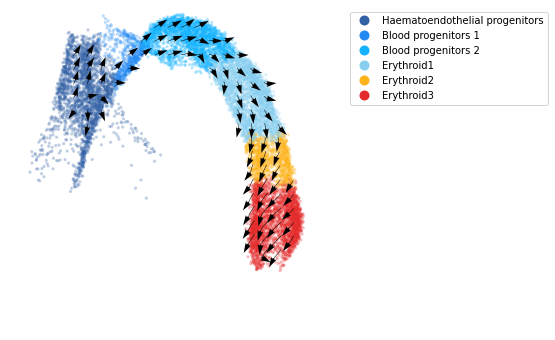

In [12]:
# load MURK gene list
murk_gene_pd=pd.read_csv('your_path/13059_2021_2414_MOESM3_ESM.csv')
murk_gene_list=list(murk_gene_pd['index'])

# compute cell velocity
cellDancer_df_murk=cd.compute_cell_velocity(cellDancer_df=cellDancer_df,
                                            gene_list=murk_gene_list,
                                            projection_neighbor_choice='gene',
                                            expression_scale='power10',
                                            projection_neighbor_size=10,
                                            speed_up=(100,100))
# plot cell velocity
fig, ax = plt.subplots(figsize=(6,6))
im = cdplt.scatter_cell(ax,
                        cellDancer_df_murk, 
                        colors=colormap.colormap_erythroid, 
                        alpha=0.3, 
                        s=10,
                        velocity=True, 
                        custom_xlim=[-6,13], 
                        custom_ylim=[2,16], 
                        legend='on',
                        min_mass=30,
                        arrow_grid =(20,20))
ax.axis('off')
plt.show()